In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install -q tensorflow_datasets

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Hmmm, a sports team is in a plane crash, gets stranded on a snowy mountain, and is faced with the difficult decision to eat the flesh of their dead companions in order to survive. Sound familiar anyone? I refer to "Alive" from 1993. The only major difference here, of course, is that a big, white, drunken scare crow of a Yeti shows up a few times to drag off the dead. I guess humans taste better than yaks.<br /><br />Stupid: The man in the first scene does not have a reliable firearm when hunting the Yeti, nor does he have a backup.<br /><br />The plane crash is completely bogus. It would have either exploded in the air, exploded when it hit the ground, or become obliterated. The people would not have survived, but hey, it\'s sci-fi.<br /><br />Stupid: They survived, and they are cold. It might be a good idea to harness some of the burning debris nearby so as not to freeze to death. Fire being warm as it is...<br /><br />WTF: The pilot has frost formed all over his face while

In [10]:
VOCAB_SIZE=1500
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:30]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one'], dtype='<U14')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   4,   1, ...,   0,   0,   0],
       [ 49, 238,   5, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Hmmm, a sports team is in a plane crash, gets stranded on a snowy mountain, and is faced with the difficult decision to eat the flesh of their dead companions in order to survive. Sound familiar anyone? I refer to "Alive" from 1993. The only major difference here, of course, is that a big, white, drunken scare crow of a Yeti shows up a few times to drag off the dead. I guess humans taste better than yaks.<br /><br />Stupid: The man in the first scene does not have a reliable firearm when hunting the Yeti, nor does he have a backup.<br /><br />The plane crash is completely bogus. It would have either exploded in the air, exploded when it hit the ground, or become obliterated. The people would not have survived, but hey, it\'s sci-fi.<br /><br />Stupid: They survived, and they are cold. It might be a good idea to harness some of the burning debris nearby so as not to freeze to death. Fire being warm as it is...<br /><br />WTF: The pilot has frost formed all over his face whi

In [14]:
#multi-layer lstm
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

*The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking.*

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00835319]


In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 130ms/step
[0.00835319]


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adamax(1e-3),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=4)

Epoch 1/2
391/391 [==============================] - 83s 169ms/step - loss: 0.5075 - accuracy: 0.7134 - val_loss: 0.3918 - val_accuracy: 0.8398
Epoch 2/2
391/391 [==============================] - 46s 116ms/step - loss: 0.3249 - accuracy: 0.8605 - val_loss: 0.3710 - val_accuracy: 0.8516


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 51ms/step - loss: 0.3084 - accuracy: 0.8743
Test Loss: 0.3084041476249695
Test Accuracy: 0.8742799758911133


In [21]:
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plot_graphs(history, 'accuracy')
# plt.ylim(None,1)
# plt.subplot(1,2,2)
# plot_graphs(history, 'loss')
# plt.ylim(0,None)

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 5s 5s/step


In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adamax(1e-3),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=4)

Epoch 1/2
391/391 [==============================] - 74s 152ms/step - loss: 0.5397 - accuracy: 0.6694 - val_loss: 0.3997 - val_accuracy: 0.8047
Epoch 2/2
391/391 [==============================] - 46s 116ms/step - loss: 0.3274 - accuracy: 0.8566 - val_loss: 0.3601 - val_accuracy: 0.8477


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 19s 49ms/step - loss: 0.3024 - accuracy: 0.8616
Test Loss: 0.30237656831741333
Test Accuracy: 0.8615999817848206


In [29]:
# predict on a sample text without padding.

sample_text = ('The movie was awesome and the first part was intesting')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 22ms/step
[[1.1515176]]


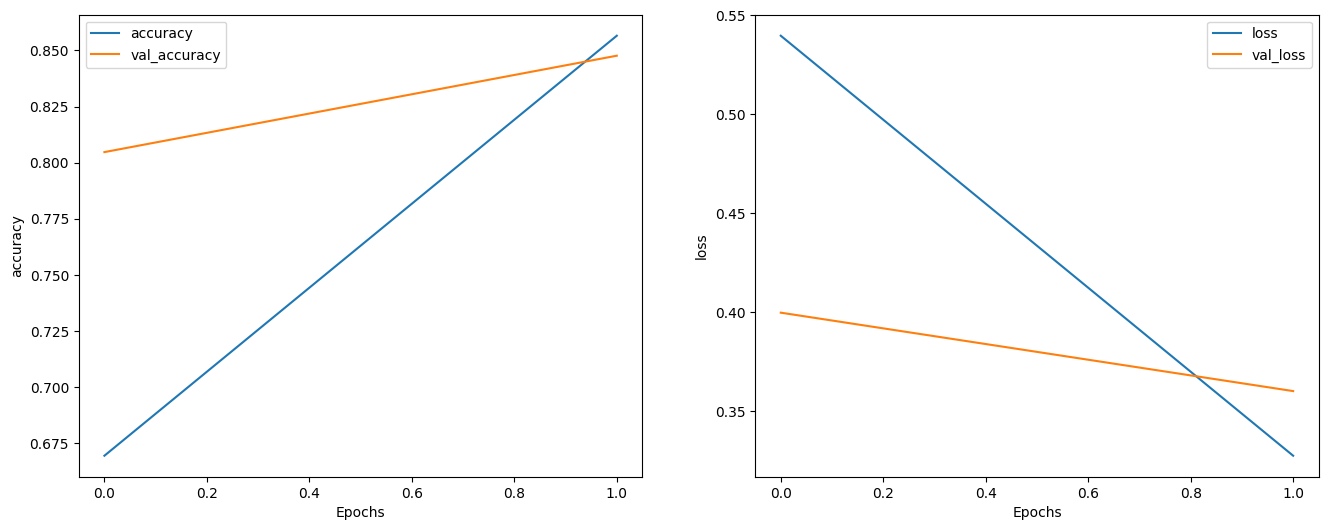

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')